In [1]:
import sys,os,glob,copy
sys.path.append('../')
import numpy as np
from statistics import median, mean
from numpy.linalg import norm
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.interpolate import LinearNDInterpolator,interp2d, griddata
from itertools import product
import matplotlib as mpl
from matplotlib.colors import LogNorm
from IPython.display import display, Markdown
import glob
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

plt.rcParams.update({"savefig.dpi" : 300}) #Figure resolution


#Define plotting style:
sns.set() #Set style
sns.set_style('ticks',{'font.family':'Times New Roman', 'font.serif':'Times New Roman'})
sns.set_context('paper', font_scale=1.8)
cm = plt.cm.get_cmap('RdYlBu')


pd.set_option('display.max_rows', 200)

### Load Recast Data

In [3]:
# Load models (axial and vector)
inputFiles = ['../scanResults_axial.pcl', '../scanResults_vector.pcl']
dfs = [pd.read_pickle(i) for i in inputFiles]
recastData = pd.concat(dfs, ignore_index=True)

### Get model points

In [4]:
models = []
mCols = ['Coupling', 'Mode', '$m_{med}$', '$m_{DM}$']
for row in recastData[mCols].values:
    m = dict(zip(mCols, row.tolist()))
    if m not in models:
        models.append(m)

print('%i models loaded.' %len(models))

376 models loaded.


### Get model parameters

In [5]:
parameters = {label : list(set([m[label] for m in models])) for label in mCols}
for k,v in parameters.items():
    if len(v) == 1:
        parameters[k] = v[0]
print(parameters)

textstr = '\n'.join([r'%s = %s' %(k,v) for k,v in parameters.items() if k not in ['$m_{med}$','$m_{DM}$']])
print(textstr)

{'Coupling': ['Axial', 'Vector'], 'Mode': 'DM+QCDjets', '$m_{med}$': [450.0, 1250.0, 100.0, 2500.0, 200.0, 1000.0, 2250.0, 300.0, 750.0, 400.0, 2000.0, 500.0, 1750.0, 3000.0, 250.0, 1500.0, 2750.0], '$m_{DM}$': [1.0, 1400.0, 900.0, 650.0, 400.0, 150.0, 30.0, 800.0, 40.0, 300.0, 45.0, 1200.0, 50.0, 55.0, 700.0, 60.0, 450.0, 70.0, 200.0, 75.0, 1100.0, 80.0, 600.0, 90.0, 1500.0, 350.0, 100.0, 1000.0, 750.0, 500.0, 120.0, 250.0]}
Coupling = ['Axial', 'Vector']
Mode = DM+QCDjets


### Obtain Efficiencies

In [6]:
label = [c for c in recastData if (c.startswith("bin_") and not 'Error' in c)]

for l in label:
    ns = recastData[l]
    lumi = recastData['Luminosity (1/fb)']
    xsec = recastData['Total xsec (pb)']
    recastData[f'{l}_Efficiency'] = ns/(1e3*xsec*lumi)

# Obtain the median of the binned efficiencies
# recastData['Median_Efficiency'] = recastData[[f'{l}_Efficiency' for l in label]].apply(median, axis=1)      

In [7]:
recastData.T

,0,1,2,3,4,5,6,7,8,9,...,1118,1119,1120,1121,1122,1123,1124,1125,1126,1127
Coupling,Axial,Axial,Axial,Axial,Axial,Axial,Axial,Axial,Axial,Axial,...,Vector,Vector,Vector,Vector,Vector,Vector,Vector,Vector,Vector,Vector
Mode,DM+QCDjets,DM+QCDjets,DM+QCDjets,DM+QCDjets,DM+QCDjets,DM+QCDjets,DM+QCDjets,DM+QCDjets,DM+QCDjets,DM+QCDjets,...,DM+QCDjets,DM+QCDjets,DM+QCDjets,DM+QCDjets,DM+QCDjets,DM+QCDjets,DM+QCDjets,DM+QCDjets,DM+QCDjets,DM+QCDjets
$m_{med}$,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,...,3000.0,3000.0,3000.0,3000.0,3000.0,3000.0,3000.0,3000.0,3000.0,3000.0
$m_{DM}$,1.0,1.0,1.0,30.0,30.0,30.0,40.0,40.0,40.0,45.0,...,800.0,1000.0,1000.0,1000.0,1200.0,1200.0,1200.0,1400.0,1400.0,1400.0
Data-takingperiod,2018,2017,2016,2018,2017,2016,2018,2017,2016,2018,...,2016,2018,2017,2016,2018,2017,2016,2018,2017,2016
Luminosity (1/fb),59.7,41.5,36.0,59.7,41.5,36.0,59.7,41.5,36.0,59.7,...,36.0,59.7,41.5,36.0,59.7,41.5,36.0,59.7,41.5,36.0
bin_250.0_280.0,152085.040901,108400.202412,80969.111724,93539.296706,80357.159796,78680.560578,53471.496926,41948.850961,31657.09069,25173.660888,...,12.214073,15.635484,13.101446,13.429174,13.874972,13.038499,10.495754,10.693503,8.944249,8.173984
bin_250.0_280.0_ErrorPlus,12314.891239,10133.267892,11571.391951,7934.150234,7492.10935,8786.26641,5053.089059,3861.644759,3525.196942,2153.626755,...,1.424952,0.856903,0.791472,0.784591,0.763866,0.740669,0.662238,0.555894,0.505149,0.47744
bin_250.0_280.0_ErrorMinus,12314.891239,10133.267892,11571.391951,7934.150234,7492.10935,8786.26641,5053.089059,3861.644759,3525.196942,2153.626755,...,1.424952,0.856903,0.791472,0.784591,0.763866,0.740669,0.662238,0.555894,0.505149,0.47744
bin_280.0_310.0,66541.375367,77381.412251,58531.001086,56340.462471,45985.445157,46403.405054,31845.981284,23192.140623,23731.224627,12784.839226,...,12.862366,14.452958,10.829227,10.402269,11.357604,10.437915,8.752438,7.969646,6.74878,5.616473


In [8]:
# Select year
recastData = recastData[recastData['Data-takingperiod'] == 2017]

In [9]:
dataAx = recastData[recastData['Coupling'] == 'Axial']
dataVec = recastData[recastData['Coupling'] == 'Vector']

In [10]:
dataAx

,Coupling,Mode,$m_{med}$,$m_{DM}$,Data-takingperiod,Luminosity (1/fb),bin_250.0_280.0,bin_250.0_280.0_ErrorPlus,bin_250.0_280.0_ErrorMinus,bin_280.0_310.0,...,bin_690.0_740.0_Efficiency,bin_740.0_790.0_Efficiency,bin_790.0_840.0_Efficiency,bin_840.0_900.0_Efficiency,bin_900.0_960.0_Efficiency,bin_960.0_1020.0_Efficiency,bin_1020.0_1090.0_Efficiency,bin_1090.0_1160.0_Efficiency,bin_1160.0_1250.0_Efficiency,bin_1250.0_1400.0_Efficiency
1,Axial,DM+QCDjets,100.0,1.0,2017,41.5,108400.202412,10133.267892,10133.267892,77381.412251,...,1.489752e-06,3.981423e-07,5.121838e-07,0.000000e+00,1.215611e-07,0.000000e+00,1.632824e-07,0.000000e+00,0.000000e+00,7.639477e-08
4,Axial,DM+QCDjets,100.0,30.0,2017,41.5,80357.159796,7492.109350,7492.109350,45985.445157,...,1.338366e-06,1.124530e-06,4.248373e-07,1.661400e-07,2.785625e-07,9.129850e-08,1.007542e-07,0.000000e+00,0.000000e+00,6.671278e-08
7,Axial,DM+QCDjets,100.0,40.0,2017,41.5,41948.850961,3861.644759,3861.644759,23192.140623,...,8.251882e-07,8.885191e-07,1.473864e-07,1.663233e-07,1.326586e-07,1.111130e-07,1.872870e-07,7.203179e-08,8.120846e-08,5.289951e-08
10,Axial,DM+QCDjets,100.0,45.0,2017,41.5,23201.620871,2055.454655,2055.454655,16704.193201,...,1.178523e-06,6.731475e-07,6.229495e-07,6.994521e-07,1.291749e-07,1.096530e-07,1.021542e-07,1.168637e-07,1.317462e-07,2.540663e-08
13,Axial,DM+QCDjets,100.0,55.0,2017,41.5,2888.063568,205.521407,205.521407,2771.651015,...,4.646419e-06,9.251280e-06,3.718409e-06,4.257863e-06,1.676056e-06,2.210872e-06,1.146352e-06,5.220857e-07,0.000000e+00,3.843207e-07
16,Axial,DM+QCDjets,100.0,60.0,2017,41.5,2068.116084,145.763778,145.763778,1431.985861,...,1.660484e-05,8.663160e-06,7.494886e-06,5.509454e-06,2.750766e-06,2.880062e-06,9.940530e-07,1.422876e-06,1.437524e-06,1.162048e-06
19,Axial,DM+QCDjets,100.0,70.0,2017,41.5,1474.676981,100.697917,100.697917,1141.521203,...,2.509792e-05,1.325594e-05,1.306853e-05,6.694204e-06,4.208609e-06,1.922299e-06,1.007097e-06,1.100419e-06,1.289250e-06,1.573731e-06
22,Axial,DM+QCDjets,100.0,100.0,2017,41.5,722.183274,52.777722,52.777722,490.243118,...,6.003918e-05,4.655409e-05,4.130590e-05,2.018568e-05,2.992325e-05,1.058254e-05,6.736355e-06,6.981932e-06,4.398118e-06,5.314885e-06
25,Axial,DM+QCDjets,100.0,120.0,2017,41.5,403.494264,26.925740,26.925740,296.450663,...,1.225284e-04,7.715429e-05,8.300465e-05,3.601431e-05,3.926321e-05,2.733260e-05,1.908188e-05,6.963700e-06,8.329629e-06,1.060012e-05
28,Axial,DM+QCDjets,100.0,150.0,2017,41.5,312.298139,24.907733,24.907733,182.739001,...,1.663580e-04,1.087733e-04,1.076643e-04,7.808211e-05,4.645683e-05,3.259273e-05,2.206551e-05,1.934484e-05,1.398149e-05,2.211012e-05


In [11]:
# Setting the index with mass pairs
effAx = pd.DataFrame([dataAx.set_index(['$m_{med}$', '$m_{DM}$'])[c] for c in recastData if 'Efficiency' in c])
effVec = pd.DataFrame([dataVec.set_index(['$m_{med}$', '$m_{DM}$'])[c] for c in recastData if 'Efficiency' in c])

In [12]:
diff = []
for med, dm in effVec:
    d = np.abs(effAx[med, dm] - effVec[med, dm])/effAx[med, dm]
    d = d.replace(np.inf, 0)
    d = d.max()
    diff.append(d)

In [13]:
len(diff)

188

In [14]:
max(diff)

18.316055373574542

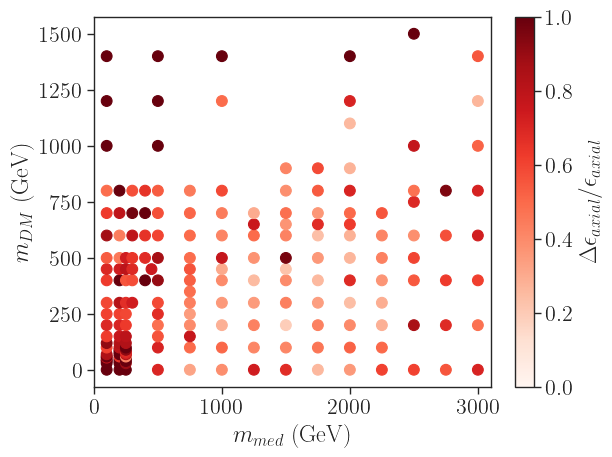

In [15]:
# Plot results
plt.scatter(x=dataVec['$m_{med}$'], y=dataVec['$m_{DM}$'], vmin=0., vmax=1., c=diff, 
            cmap=plt.cm.get_cmap('Reds'), s=60)

cbar=plt.colorbar(label=r'$\Delta \epsilon_{axial}/\epsilon_{axial}$')
plt.xlabel(r'$m_{med}$ (GeV)')
plt.xlim(0,3100)
plt.ylabel(r'$m_{DM}$ (GeV)')
# plt.ylim(-10,1500)
plt.show()

In [16]:
pts = np.array([x for x in product(np.linspace(0.,3000.,100),np.linspace(0.,1500.,100))])
relDiffPts = griddata(list(zip(dataVec['$m_{med}$'],dataVec['$m_{DM}$'])),
                  diff,pts)
pts = pts[~np.isnan(relDiffPts)]
relDiffPts = relDiffPts[~np.isnan(relDiffPts)]

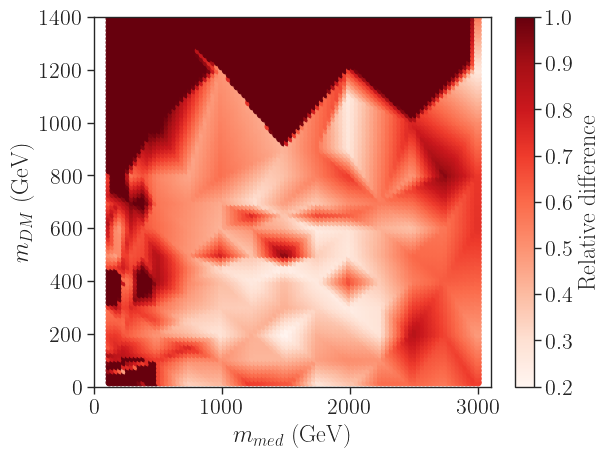

In [17]:
plt.scatter(x=pts[:,0], y=pts[:,1], vmin=0.2, vmax =1., 
            c=relDiffPts, cmap=plt.cm.get_cmap('Reds'))
cbar = plt.colorbar(label='Relative difference')

plt.xlabel(r'$m_{med}$ (GeV)')
plt.xlim(0,3100)
plt.ylabel(r'$m_{DM}$ (GeV)')
plt.ylim(0,1400)
plt.show()

In [17]:
def getBins(dfModel,rightBin = 2000.):
    
    bins = {c : eval(c.split('_')[1]) for c in dfModel.columns if ("bin_" in c and 'Efficiency' in c)}
    binsError = {c : eval(c.split('_')[1]) for c in dfModel.columns if ("bin_" in c and 'ErrorPlus' in c)}    
    binCenter = (np.array(list(bins.values()))+np.diff(list(bins.values())+[rightBin])/2).tolist()    
    binLeft = [bins[c] for c in bins]+[rightBin] 
    
    return binsEff,binsError,binCenter,binLeft

In [20]:
# Create function that receives two dataframes, compares the efficiency in each bin, 
# and then returns the largest relative difference

def getRelativeDifference(dfSingle1, dfSingle2, binsEff):
    pass
    
    